<a href="https://colab.research.google.com/github/Rafay212/Customer-Churn-Prediction-Bank-Customers-/blob/main/Customer_Churn_Prediction_(Bank_Customers).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("="*70)
print("="*70)

TASK 3: CUSTOMER CHURN PREDICTION (SIMPLE VERSION)


In [2]:
# ============================================
# STEP 1: Load Data
# ============================================
print("\n[STEP 1] Loading Dataset...")

try:
    # Try to load real data
    df = pd.read_csv('/content/Churn Modeling.csv')
    print("✓ Real dataset loaded!")
    using_real_data = True
except:
    # Create sample data if file not found
    print("⚠ Creating sample data for demonstration...")
    np.random.seed(42)
    n = 1000

    df = pd.DataFrame({
        'RowNumber': range(1, n+1),
        'CustomerId': range(15000000, 15000000+n),
        'Surname': [f'Customer_{i}' for i in range(n)],
        'CreditScore': np.random.randint(350, 850, n),
        'Geography': np.random.choice(['France', 'Germany', 'Spain'], n),
        'Gender': np.random.choice(['Male', 'Female'], n),
        'Age': np.random.randint(18, 70, n),
        'Tenure': np.random.randint(0, 11, n),
        'Balance': np.random.uniform(0, 250000, n),
        'NumOfProducts': np.random.choice([1, 2, 3, 4], n, p=[0.5, 0.3, 0.15, 0.05]),
        'HasCrCard': np.random.choice([0, 1], n, p=[0.3, 0.7]),
        'IsActiveMember': np.random.choice([0, 1], n, p=[0.4, 0.6]),
        'EstimatedSalary': np.random.uniform(10000, 200000, n)
    })

    # Create target with realistic patterns
    df['Exited'] = 0
    # Higher churn for older customers
    df.loc[df['Age'] > 50, 'Exited'] = np.random.choice([0, 1],
        sum(df['Age'] > 50), p=[0.6, 0.4])
    # Higher churn for inactive members
    df.loc[df['IsActiveMember'] == 0, 'Exited'] = np.random.choice([0, 1],
        sum(df['IsActiveMember'] == 0), p=[0.5, 0.5])
    # Higher churn for Germany
    df.loc[df['Geography'] == 'Germany', 'Exited'] = np.random.choice([0, 1],
        sum(df['Geography'] == 'Germany'), p=[0.6, 0.4])

    using_real_data = False

print(f"  Dataset shape: {df.shape}")
print(f"  Rows: {df.shape[0]}, Columns: {df.shape[1]}")


[STEP 1] Loading Dataset...
✓ Real dataset loaded!
  Dataset shape: (10000, 14)
  Rows: 10000, Columns: 14


In [3]:
# ============================================
# STEP 2: Quick Look at Data
# ============================================
print("\n[STEP 2] Quick Data Overview...")

print("\n📊 First 5 rows:")
print(df.head())

print("\n📊 Churn Distribution:")
churn_counts = df['Exited'].value_counts()
print(churn_counts)
print(f"\nCustomers who stayed: {churn_counts[0]} ({churn_counts[0]/len(df)*100:.1f}%)")
print(f"Customers who left: {churn_counts[1]} ({churn_counts[1]/len(df)*100:.1f}%)")

print("\n📊 Missing values:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("  ✓ No missing values!")
else:
    print(missing[missing > 0])


[STEP 2] Quick Data Overview...

📊 First 5 rows:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57   


[STEP 3] Exploring Key Features...


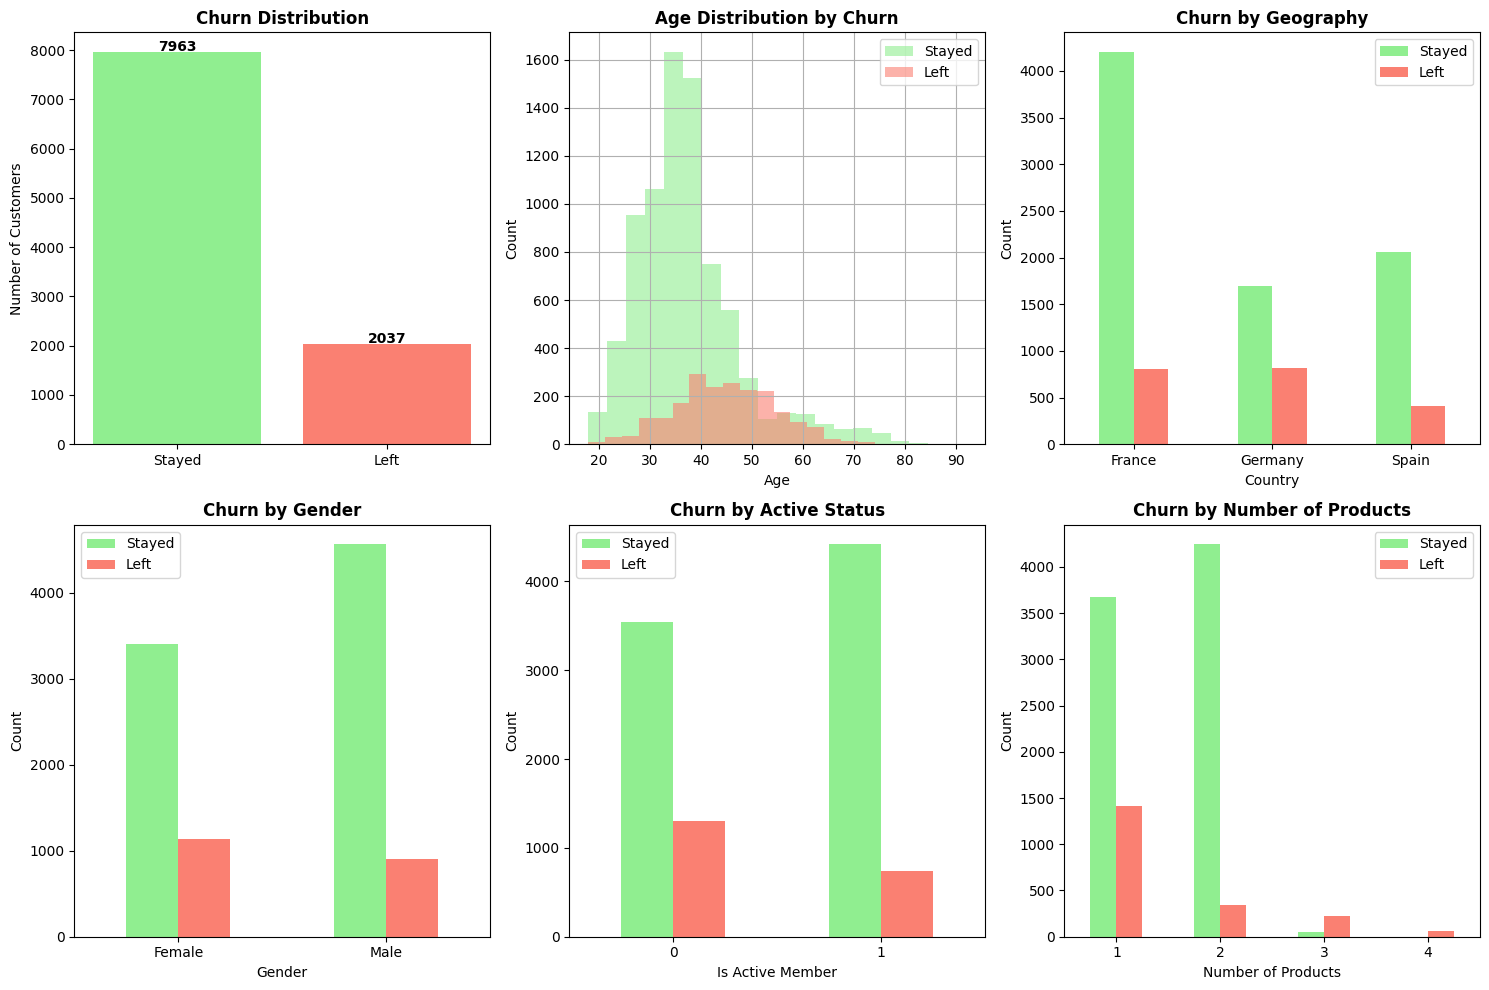

  ✓ Charts saved as 'task3_simple_eda.png'


In [4]:
# ============================================
# STEP 3: Simple Data Exploration
# ============================================
print("\n[STEP 3] Exploring Key Features...")

# Create 6 simple visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Churn distribution
axes[0, 0].bar(['Stayed', 'Left'], churn_counts.values, color=['lightgreen', 'salmon'])
axes[0, 0].set_title('Churn Distribution', fontweight='bold')
axes[0, 0].set_ylabel('Number of Customers')
for i, v in enumerate(churn_counts.values):
    axes[0, 0].text(i, v + 20, str(v), ha='center', fontweight='bold')

# 2. Age vs Churn
df[df['Exited']==0]['Age'].hist(bins=20, alpha=0.6, label='Stayed',
                                 color='lightgreen', ax=axes[0, 1])
df[df['Exited']==1]['Age'].hist(bins=20, alpha=0.6, label='Left',
                                 color='salmon', ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution by Churn', fontweight='bold')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend()

# 3. Geography vs Churn
geo_churn = pd.crosstab(df['Geography'], df['Exited'])
geo_churn.plot(kind='bar', ax=axes[0, 2], color=['lightgreen', 'salmon'])
axes[0, 2].set_title('Churn by Geography', fontweight='bold')
axes[0, 2].set_xlabel('Country')
axes[0, 2].set_ylabel('Count')
axes[0, 2].legend(['Stayed', 'Left'])
axes[0, 2].tick_params(axis='x', rotation=0)

# 4. Gender vs Churn
gender_churn = pd.crosstab(df['Gender'], df['Exited'])
gender_churn.plot(kind='bar', ax=axes[1, 0], color=['lightgreen', 'salmon'])
axes[1, 0].set_title('Churn by Gender', fontweight='bold')
axes[1, 0].set_xlabel('Gender')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend(['Stayed', 'Left'])
axes[1, 0].tick_params(axis='x', rotation=0)

# 5. Active Member vs Churn
active_churn = pd.crosstab(df['IsActiveMember'], df['Exited'])
active_churn.plot(kind='bar', ax=axes[1, 1], color=['lightgreen', 'salmon'])
axes[1, 1].set_title('Churn by Active Status', fontweight='bold')
axes[1, 1].set_xlabel('Is Active Member')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend(['Stayed', 'Left'])
axes[1, 1].tick_params(axis='x', rotation=0)

# 6. Number of Products vs Churn
products_churn = pd.crosstab(df['NumOfProducts'], df['Exited'])
products_churn.plot(kind='bar', ax=axes[1, 2], color=['lightgreen', 'salmon'])
axes[1, 2].set_title('Churn by Number of Products', fontweight='bold')
axes[1, 2].set_xlabel('Number of Products')
axes[1, 2].set_ylabel('Count')
axes[1, 2].legend(['Stayed', 'Left'])
axes[1, 2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('task3_simple_eda.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Charts saved as 'task3_simple_eda.png'")

In [5]:
# ============================================
# STEP 4: Prepare Data for Model
# ============================================
print("\n[STEP 4] Preparing Data...")

# Make a copy
df_clean = df.copy()

# Remove unnecessary columns
columns_to_remove = ['RowNumber', 'CustomerId', 'Surname']
df_clean = df_clean.drop(columns_to_remove, axis=1)
print(f"  ✓ Removed: {columns_to_remove}")

# Encode categorical variables
print("\n  Encoding categories...")

# 1. Gender: Male/Female → 0/1
df_clean['Gender'] = LabelEncoder().fit_transform(df_clean['Gender'])
print("    ✓ Gender: Male=0, Female=1")

# 2. Geography: Create dummy variables
geography_dummies = pd.get_dummies(df_clean['Geography'], prefix='Geo')
df_clean = pd.concat([df_clean, geography_dummies], axis=1)
df_clean = df_clean.drop('Geography', axis=1)
print(f"    ✓ Geography: Created {len(geography_dummies.columns)} columns")

print(f"\n  Final features: {df_clean.shape[1] - 1} (excluding target)")


[STEP 4] Preparing Data...
  ✓ Removed: ['RowNumber', 'CustomerId', 'Surname']

  Encoding categories...
    ✓ Gender: Male=0, Female=1
    ✓ Geography: Created 3 columns

  Final features: 12 (excluding target)


In [6]:
# ============================================
# STEP 5: Split Data
# ============================================
print("\n[STEP 5] Splitting Data...")

# Separate features (X) and target (y)
X = df_clean.drop('Exited', axis=1)
y = df_clean['Exited']

# Split: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"  Training data: {len(X_train)} customers")
print(f"  Testing data: {len(X_test)} customers")


[STEP 5] Splitting Data...
  Training data: 8000 customers
  Testing data: 2000 customers


In [7]:
# ============================================
# STEP 6: Train Model
# ============================================
print("\n[STEP 6] Training Model...")

# Use Random Forest (works well, easy to understand)
model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
model.fit(X_train, y_train)

print("  ✓ Model trained successfully!")

# ============================================
# STEP 7: Make Predictions
# ============================================
print("\n[STEP 7] Making Predictions...")

# Predict on test data
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n  Model Accuracy: {accuracy:.2%}")
print(f"  → Correctly predicted {int(accuracy * len(y_test))} out of {len(y_test)} customers")


[STEP 6] Training Model...
  ✓ Model trained successfully!

[STEP 7] Making Predictions...

  Model Accuracy: 86.55%
  → Correctly predicted 1731 out of 2000 customers



[STEP 8] Model Evaluation...


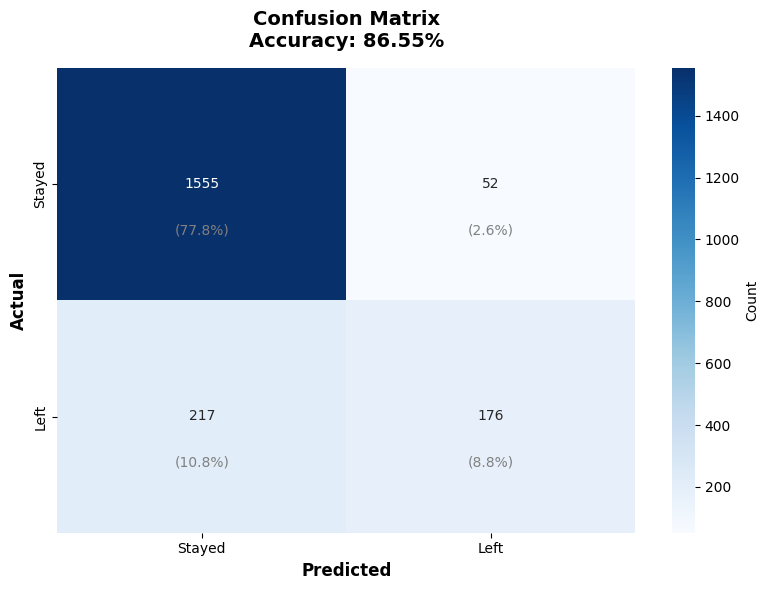

  ✓ Confusion matrix saved as 'task3_confusion_matrix.png'

📊 Classification Report:
              precision    recall  f1-score   support

      Stayed       0.88      0.97      0.92      1607
        Left       0.77      0.45      0.57       393

    accuracy                           0.87      2000
   macro avg       0.82      0.71      0.74      2000
weighted avg       0.86      0.87      0.85      2000



In [8]:
# ============================================
# STEP 8: Evaluate Model
# ============================================
print("\n[STEP 8] Model Evaluation...")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Stayed', 'Left'],
            yticklabels=['Stayed', 'Left'],
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2%}',
          fontsize=14, fontweight='bold', pad=15)
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.xlabel('Predicted', fontsize=12, fontweight='bold')

# Add percentages
for i in range(2):
    for j in range(2):
        pct = cm[i, j] / cm.sum() * 100
        plt.text(j + 0.5, i + 0.7, f'({pct:.1f}%)',
                ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.savefig('task3_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Confusion matrix saved as 'task3_confusion_matrix.png'")

# Detailed Report
print("\n📊 Classification Report:")
print("="*60)
print(classification_report(y_test, y_pred,
                           target_names=['Stayed', 'Left']))


[STEP 9] What Factors Matter Most?...

📊 Top 10 Important Features:
        Feature  Importance
            Age    0.319713
  NumOfProducts    0.225913
        Balance    0.104480
EstimatedSalary    0.079342
    CreditScore    0.079030
 IsActiveMember    0.065473
         Tenure    0.043738
    Geo_Germany    0.035538
         Gender    0.018293
     Geo_France    0.010849


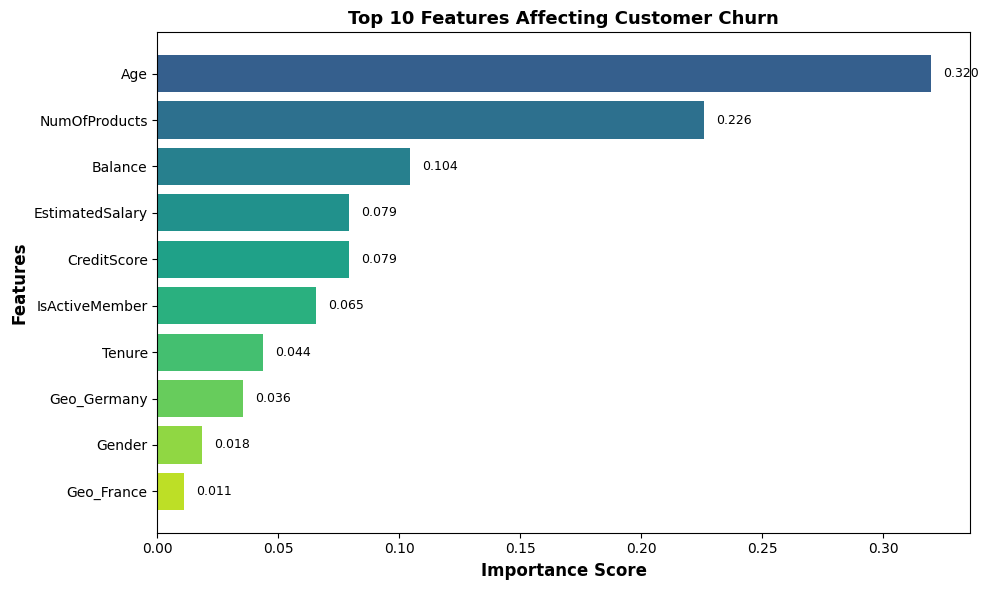

  ✓ Feature importance saved as 'task3_feature_importance.png'


In [9]:
# ============================================
# STEP 9: Feature Importance
# ============================================
print("\n[STEP 9] What Factors Matter Most?...")

# Get feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n📊 Top 10 Important Features:")
print(importance_df.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
top_10 = importance_df.head(10)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, 10))
bars = plt.barh(top_10['Feature'], top_10['Importance'], color=colors)
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('Top 10 Features Affecting Customer Churn',
          fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()

# Add values
for bar, imp in zip(bars, top_10['Importance']):
    plt.text(imp + 0.005, bar.get_y() + bar.get_height()/2,
            f'{imp:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('task3_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Feature importance saved as 'task3_feature_importance.png'")

In [11]:
# ============================================
# STEP 10: Key Insights
# ============================================
print("\n[STEP 10] Key Insights:")
print("="*70)

print("\n1. MODEL PERFORMANCE:")
print(f"   ✓ Accuracy: {accuracy:.2%}")
print(f"   ✓ The model correctly predicts {int(accuracy*100)}% of customers")

print("\n2. MOST IMPORTANT FACTORS:")
for i, row in importance_df.head(5).iterrows():
    print(f"   • {row['Feature']}: {row['Importance']:.4f}")

print("\n3. INSIGHTS FROM DATA:")
# Calculate some statistics
avg_age_left = df[df['Exited']==1]['Age'].mean()
avg_age_stayed = df[df['Exited']==0]['Age'].mean()
print(f"   • Average age of customers who left: {avg_age_left:.1f} years")
print(f"   • Average age of customers who stayed: {avg_age_stayed:.1f} years")

inactive_churn_rate = df[df['IsActiveMember']==0]['Exited'].mean() * 100
active_churn_rate = df[df['IsActiveMember']==1]['Exited'].mean() * 100
print(f"   • Inactive members churn rate: {inactive_churn_rate:.1f}%")
print(f"   • Active members churn rate: {active_churn_rate:.1f}%")

print("\n4. BUSINESS RECOMMENDATIONS:")
print("   📌 Focus on retaining older customers (age 40+)")
print("   📌 Engage inactive members with special offers")
print("   📌 Monitor customers with low account balances")
print("   📌 Create loyalty programs for long-term customers")
print("   📌 Pay attention to geographic differences")

print("\n5. ACTION ITEMS:")
print("   ✅ Identify high-risk customers using this model")
print("   ✅ Send personalized retention offers")
print("   ✅ Improve customer service in high-churn regions")
print("   ✅ Regular monitoring of customer activity")


[STEP 10] Key Insights:

1. MODEL PERFORMANCE:
   ✓ Accuracy: 86.55%
   ✓ The model correctly predicts 86% of customers

2. MOST IMPORTANT FACTORS:
   • Age: 0.3197
   • NumOfProducts: 0.2259
   • Balance: 0.1045
   • EstimatedSalary: 0.0793
   • CreditScore: 0.0790

3. INSIGHTS FROM DATA:
   • Average age of customers who left: 44.8 years
   • Average age of customers who stayed: 37.4 years
   • Inactive members churn rate: 26.9%
   • Active members churn rate: 14.3%

4. BUSINESS RECOMMENDATIONS:
   📌 Focus on retaining older customers (age 40+)
   📌 Engage inactive members with special offers
   📌 Monitor customers with low account balances
   📌 Create loyalty programs for long-term customers
   📌 Pay attention to geographic differences

5. ACTION ITEMS:
   ✅ Identify high-risk customers using this model
   ✅ Send personalized retention offers
   ✅ Improve customer service in high-churn regions
   ✅ Regular monitoring of customer activity


In [12]:
# ============================================
# STEP 11: Sample Predictions
# ============================================
print("\n[STEP 11] Example Predictions...")

# Show 5 sample predictions
sample_size = min(5, len(X_test))
sample_results = pd.DataFrame({
    'Actual': ['Stayed' if x==0 else 'Left' for x in y_test.iloc[:sample_size].values],
    'Predicted': ['Stayed' if x==0 else 'Left' for x in y_pred[:sample_size]],
    'Match': ['✓' if y_test.iloc[i] == y_pred[i] else '✗'
              for i in range(sample_size)]
})

print("\n📊 Sample Predictions:")
print(sample_results.to_string(index=True))


[STEP 11] Example Predictions...

📊 Sample Predictions:
   Actual Predicted Match
0  Stayed    Stayed     ✓
1  Stayed    Stayed     ✓
2  Stayed    Stayed     ✓
3  Stayed    Stayed     ✓
4  Stayed    Stayed     ✓
